# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

# Etapas Iniciais - **Ajustes no dataframe e preparação dos dados**


## **Monta o drive para importar arquivos**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Inicializações**

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que está disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### **Importing libs**


In [ ]:
#pip install -U pandas-profiling

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

%matplotlib inline

### **Import and concat the datasets**

Primeiro foi feita toda a análise qualitativa e seleção das colunas relevantes pelo excel e pelo python usando o comando: 
  - ProfileReport(df, minimal=True) 

Feito isso, foi reiniciada a análise, porém importando apenas as colunas desejadas, dessa forma muita memória RAM é poupada e a velocidade de execução do código é acelerada.

---

**Crtitérios para as colunas que não serão escolhidas:**
  - IDs, Links e informações não relvantes
  - Colunas repetidas ou parecidas (data = mês e ano)
  - Colunas preenchidas com textos descritivos
  - Colunas vazias ou com muito poucos dados
  - Colunas com praticamente todos os dados iguais


In [ ]:
path_dataset = Path(r'/content/drive/MyDrive/Colab Notebooks/dataset')

mes = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

colunas_selecionadas = ['host_response_time','host_response_rate','host_is_superhost', 'host_listings_count','latitude','longitude','property_type', 'room_type','accommodates','bathrooms','bedrooms','beds','bed_type', 'amenities','price','security_deposit','cleaning_fee','guests_included', 'extra_people','minimum_nights','maximum_nights','number_of_reviews', 'review_scores_rating','review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication','review_scores_location', 'review_scores_value','instant_bookable','is_business_travel_ready', 'cancellation_policy']

df = pd.DataFrame()

for arquivo in path_dataset.iterdir():
  df_aux = pd.read_csv(arquivo, low_memory = False, 
                       usecols = colunas_selecionadas)
  

  df_aux['mes'] = mes[arquivo.name[:3]] # Adiciona coluna de mês
  df_aux['ano'] = int(arquivo.name[-8:-4])

  df = df.append(df_aux) # Concatena dataframe

backup_df = df.copy() #Backup do dataset para trabalhar posteirormente

## **Manipulações gerais**

### Restaurar dataset

..., se necessário, tira todas as manipulações e volta para o dataset com todas as colunas originais

In [ ]:
df = backup_df.copy()

### **Handle missing values**

Se forem poucos valores faltando:
  * Preencher os vazios, sendo com a média, mediana, moda, zero ou outro valor interessante.
    - Desvantagem: Risco de enviezar a análise, se substituir muito valores em relação ao total de valores.
  * Apagar as linhas que não tem os dados.
   - Desvatagem: Diminui um pouco o dataset.

---

Se forem muitos valores faltantes:
  * Apagar as linhas que não tem os dados, sendo que só vale a pena se as linhas que faltam os dados forem as mesmas. 
    - Desvantagem: Diminui mmuito o dataset.

  * Apagar as colunas que tem muitos dados faltantes
    - Desvantagem: Diminui a quantidade de features que seriam analisada.

In [ ]:
df.isnull().sum()

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

Foram adotadas duas estratégias:
 - Quando falta poucos dados: Apaga as linhas
 - Quando falta muitos dados: Apaga a coluna 

In [ ]:
# Apaga colunas com poucos dados
for coluna in df:
  if df[coluna].isnull().sum() > 300000:
    df = df.drop(coluna, axis = 1)

df = df.dropna() # Apaga linhas com dados vazios

df.isnull().sum()

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
mes                         0
ano                         0
dtype: int64

### **Check data type in each columns**

In [ ]:
print(df.dtypes)
df[:1]

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
mes                           int64
ano                           int64
dtype: object


,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,mes,ano
0,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,0.0,2.0,...,2,$34.00,60,365,38,f,f,strict_14_with_grace_period,4,2018


Os valores monetários estão como string, então é necessário transformá-los em float

In [ ]:
df[['price', 'extra_people']] = df[['price', 'extra_people']].applymap(lambda x: float(x.replace("$", "").replace(",", "")))

print(df.dtypes)
df[:1]

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float64
guests_included               int64
extra_people                float64
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
mes                           int64
ano                           int64
dtype: object


,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,mes,ano
0,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,0.0,2.0,...,2,34.0,60,365,38,f,f,strict_14_with_grace_period,4,2018


### **Correlation analysis**

Seve para ver o quão relacionadas são as colunas, caso a correlação seja muito proximo a 1 ou -1, as colunas são muito parecidas. Então uma das colunas pode ser deletada.

Lembrando sempre que o nosso target é a coluna de preço ('price'), ou seja, é o que queremos prever, nosso objetivo.

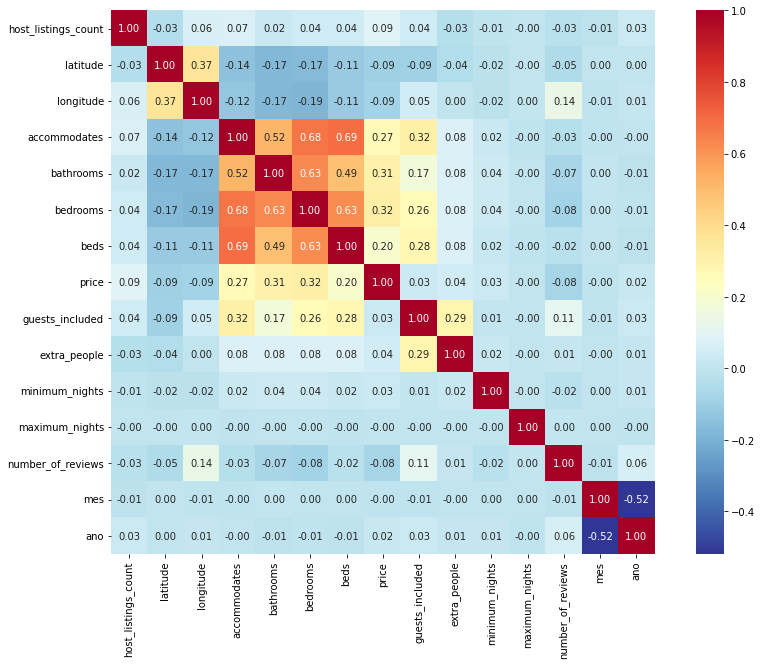

In [ ]:
plt.figure(figsize= (15,10))
sns.heatmap(df.corr(), annot = True, cmap = 'RdYlBu_r', square = True, fmt='.2f');

## **Manipulações específicas**

### **Functions and definitions to plot graphs**

##### **Outlier Analysis**


***Etapas:***
  - Analisar colunas numérica contínuas (monetárias/preços/ valores) > *'price' e 'extra_people'*
  - Analisar as colunas de valores numéricos discretos > *'accomodate', 'bedrooms', 'guests_included', ...*
  - Analisar as colunas de texto > *'host_is_superhost', 'property_type', 'room_type', 'bed_type', 'amenities', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy'*

---

**Para análise de outliers:**
Usa-se a técnica do quartil. Usando os seguintes parâmetros:
  - Q1: É o valor que separa 25% dos menores valores ou 75% dos maiores valores
  - Q2: É o valor que separa metade do dataset, seria a mediana
  - Q3: É o valor que separa 75% dos menores valores ou 25% dos maiores valores 
 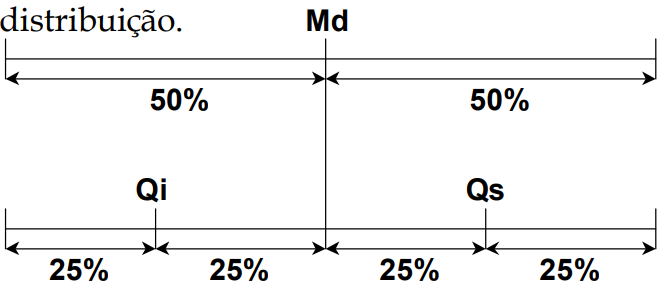
  - Amplitude: Q3 - Q1
  - Limite inferior: Q1 - 1,5* Amplitude
  - Limite superior: Q3 + 1,5* Amplitude

Depois de saber se o valor está fora dos limites, deve-se analisar qualitativamente se podemos excluir o dado.
 

In [ ]:
def limites_outlier(coluna):
  q1 = coluna.quantile(0.25)
  q3 = coluna.quantile(0.75)
  amp = q3 - q1
  lim_inf = q1 - 1.5 * amp
  lim_sup = q3 + 1.5 * amp

  return lim_inf, lim_sup

# Exemplo: limites da coluna `price`
print('Limites da coluna "price": ', limites_outlier(df['price']))


def exclui_outliers(df, coluna):
  qtd_linhas = len(df)
  lim_inf, lim_sup = limites_outlier(df[coluna])
  df = df[(df[coluna] >= lim_inf) & (df[coluna] <= lim_sup)]
  qtd_linhas_apagadas = qtd_linhas - len(df)
  return df, qtd_linhas_apagadas

Limites da coluna "price":  (-524.0, 1276.0)


In [ ]:
def diagrama_caixa(coluna):
  fig = plt.figure(figsize = (20,10))

  #boxplot com todos os dados
  fig.add_subplot(221) # matriz de 4 elementos, localizado na posicao 1
  sns.boxplot(x = coluna)

  #boxplot sem outliers (ou seja, dentro dos limites)
  fig.add_subplot(222) #matriz de 4 elementos, localizado na posicao 2
  sns.boxplot(x = coluna).set(xlim = limites_outlier(coluna))


def histograma(coluna):
  fig = plt.figure(figsize = (19,10))
  fig.add_subplot(212) # matriz de 2 linhas, localizado na posicao 2 (embaixo)
  #sns.distplot(coluna, hist = True)
  sns.histplot(coluna, kde = True, element = 'step', stat = 'density')


def grafico_barras(coluna):
  fig = plt.figure(figsize = (19,10))
  fig.add_subplot(212) # matriz de 2 linhas, localizado na posicao 2 (embaixo)
  sns.histplot(coluna, discrete = True).set(xlim = limites_outlier(coluna))


def count_plot_text(coluna):
  plt.figure(figsize = (15, 5))
  graph = sns.countplot(x = coluna, data = df)
  graph.tick_params(axis = 'x', rotation = 90)

### **Análises de valores contínuos**

#### "price" column analysis

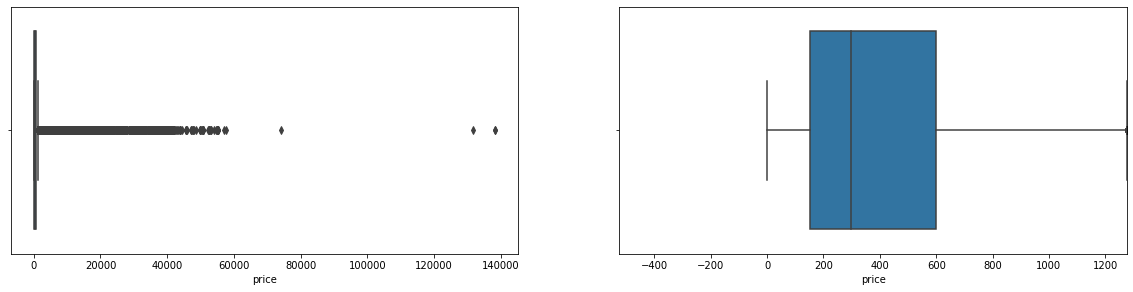

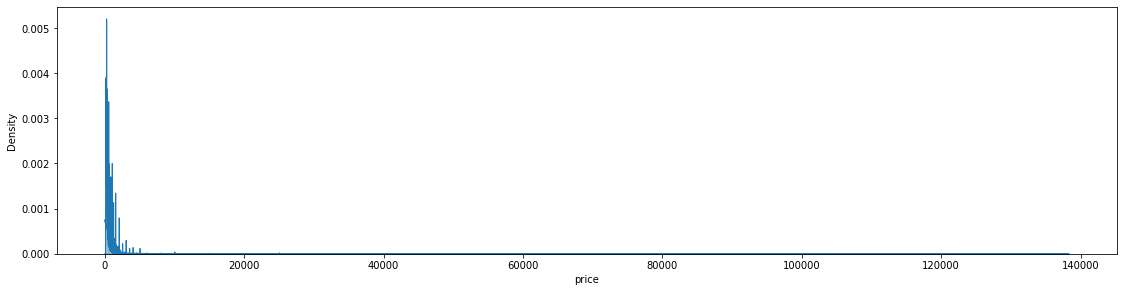

In [ ]:
diagrama_caixa(df['price'])
histograma(df['price'])

Nesse caso podemos excluir os outliers, pois estamos querendo prever o valor para casa comuns. 
Portanto alugueis com valores muito altos (casas de alto padrão) ou com valores muito baixos (valor duvidosos), podem ser excluídos.

In [ ]:
df, qtd_apagadas = exclui_outliers(df, 'price')
print('Foram excluídas {} linhas.'.format(qtd_apagadas))

Foram excluídas 87282 linhas.


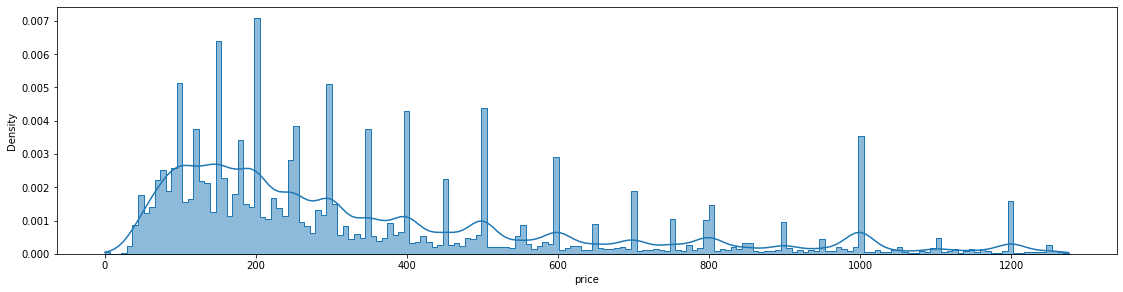

In [ ]:
histograma(df['price'])

#### "extra_people" column analysis

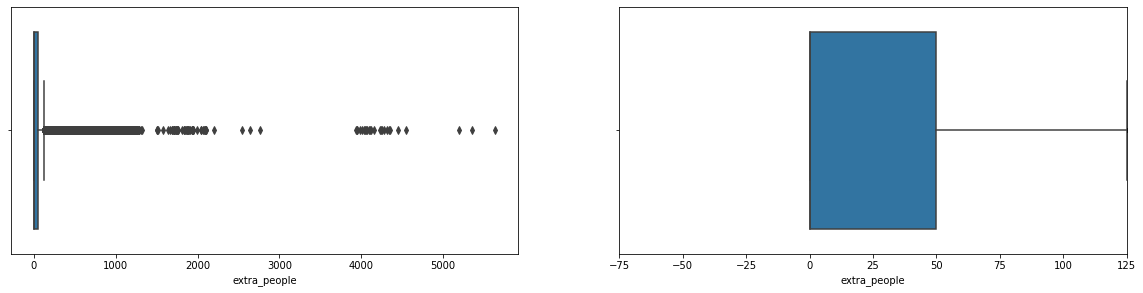

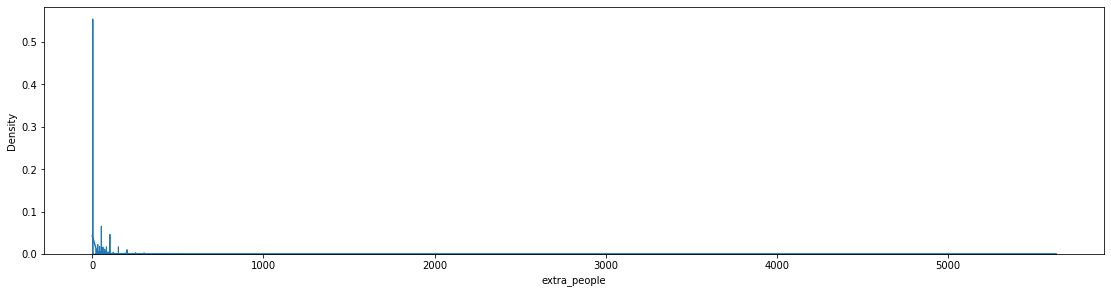

In [ ]:
diagrama_caixa(df['extra_people'])
histograma(df['extra_people'])

Nesse caso vamos excluir os outliers por intuição, sem maior critério, caso seja desejado, podemos testar o modelo novamente sem apagar esses outliers.

In [ ]:
df, qtd_apagadas = exclui_outliers(df, 'extra_people')
print('Foram excluídas {} linhas.'.format(qtd_apagadas))

Foram excluídas 59194 linhas.


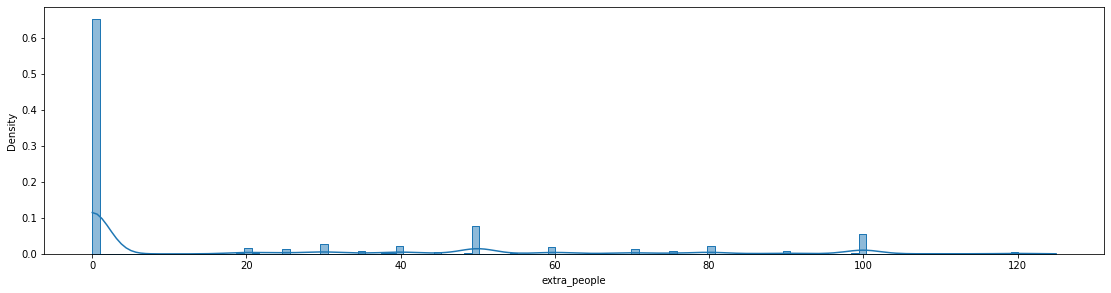

In [ ]:
histograma(df['extra_people'])

### **Análises de valores discretos**

#### "host_listings_count" column analysis

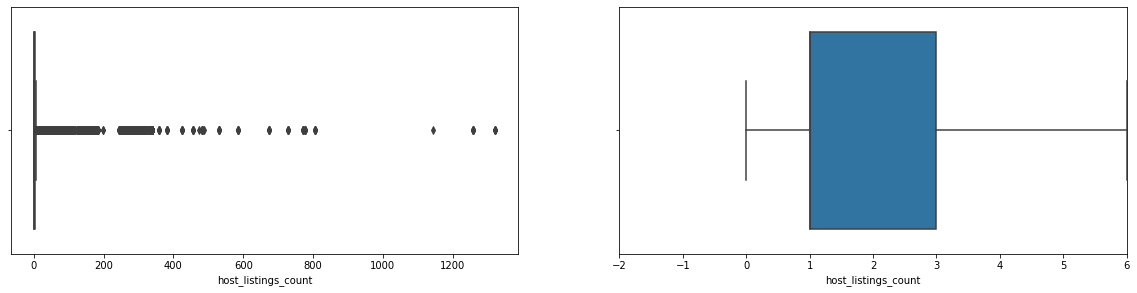

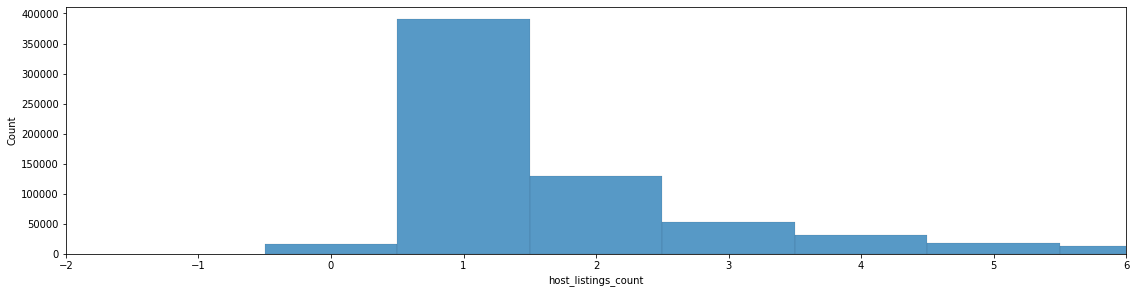

In [ ]:
diagrama_caixa(df['host_listings_count'])
grafico_barras(df['host_listings_count'])

Nesse caso podemos excluir os outliers, pois estamos querendo prever o valor para usuários comuns.
Portanto pessoas com muitas casas (imobiliárias ou profissionais da área) podem ser excluídos, pois não são nosso público alvo.

In [ ]:
df, qtd_apagadas = exclui_outliers(df, 'host_listings_count')
print('Foram excluídas {} linhas.'.format(qtd_apagadas))

Foram excluídas 97723 linhas.


#### "accommodates" column analysis

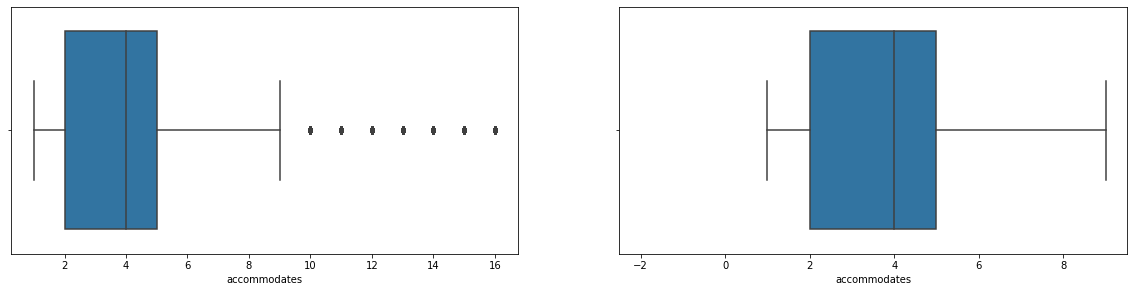

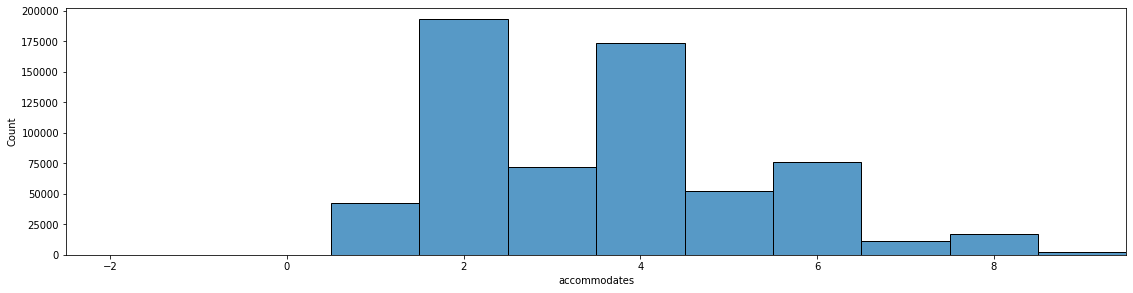

In [ ]:
diagrama_caixa(df['accommodates'])
grafico_barras(df['accommodates'])

Como existem poucos outliers, podemos excluir, pois eles não farão falta para a análise final. 

Poderiam ser deixados, por serem poucos também não impactariam muito o resultado, então por padrão serão excluídos.

In [ ]:
df, qtd_apagadas = exclui_outliers(df, 'accommodates')
print('Foram excluídas {} linhas.'.format(qtd_apagadas))

Foram excluídas 13146 linhas.


#### "bathrooms" column analysis

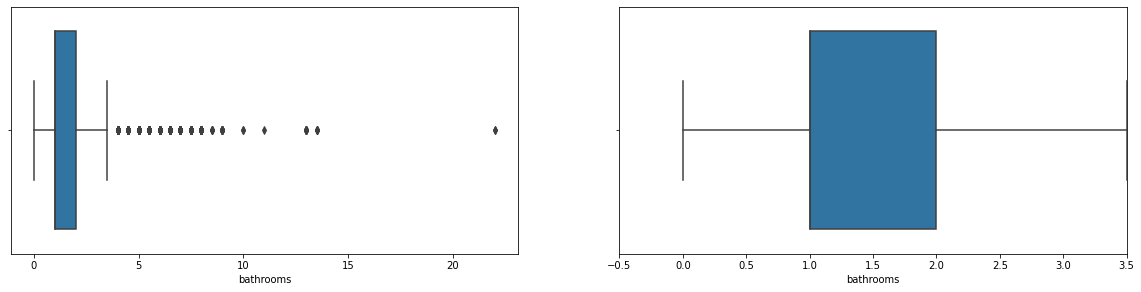

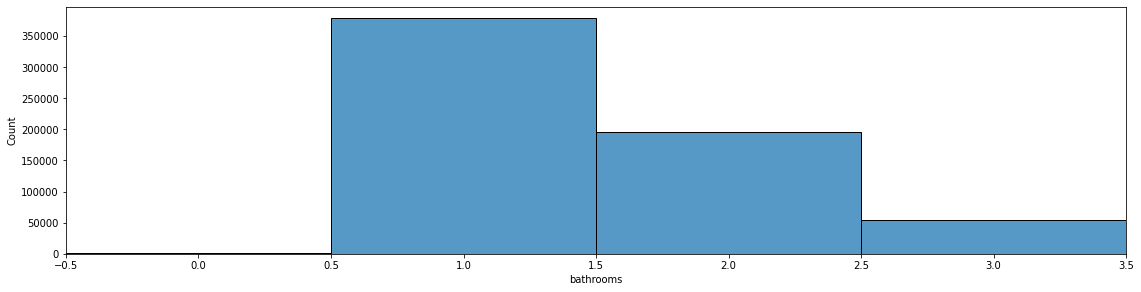

In [ ]:
diagrama_caixa(df['bathrooms'])
grafico_barras(df['bathrooms'])

Como existem poucos outliers, podemos excluir, pois eles não farão falta para a análise final. 

Poderiam ser deixados, por serem poucos também não impactariam muito o resultado, então por padrão serão excluídos.

In [ ]:
df, qtd_apagadas = exclui_outliers(df, 'bathrooms')
print('Foram excluídas {} linhas.'.format(qtd_apagadas))

Foram excluídas 6894 linhas.


#### "bedrooms" column analysis

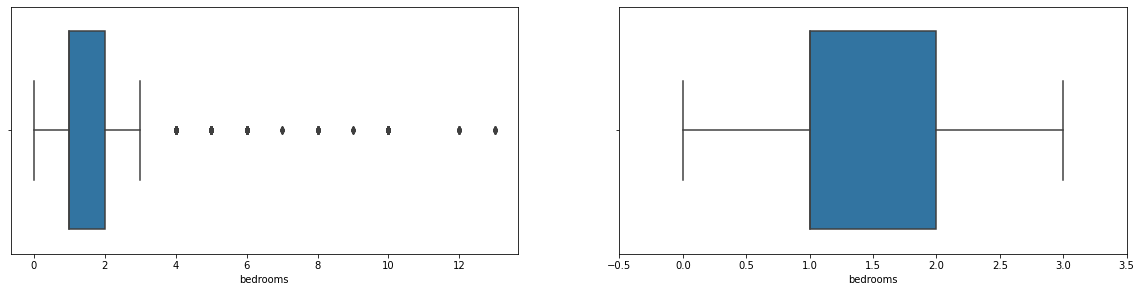

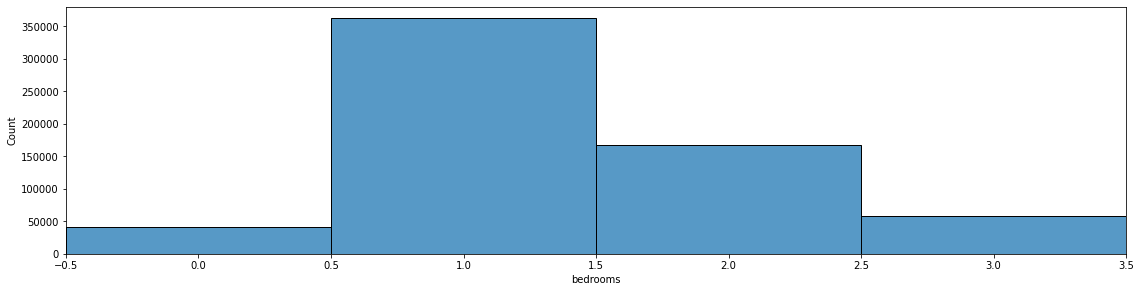

In [ ]:
diagrama_caixa(df['bedrooms'])
grafico_barras(df['bedrooms'])

Como existem poucos outliers, podemos excluir, pois eles não farão falta para a análise final. 

Poderiam ser deixados, por serem poucos também não impactariam muito o resultado, então por padrão serão excluídos.

In [ ]:
df, qtd_apagadas = exclui_outliers(df, 'bedrooms')
print('Foram excluídas {} linhas.'.format(qtd_apagadas))

Foram excluídas 5482 linhas.


#### "beds" column analysis

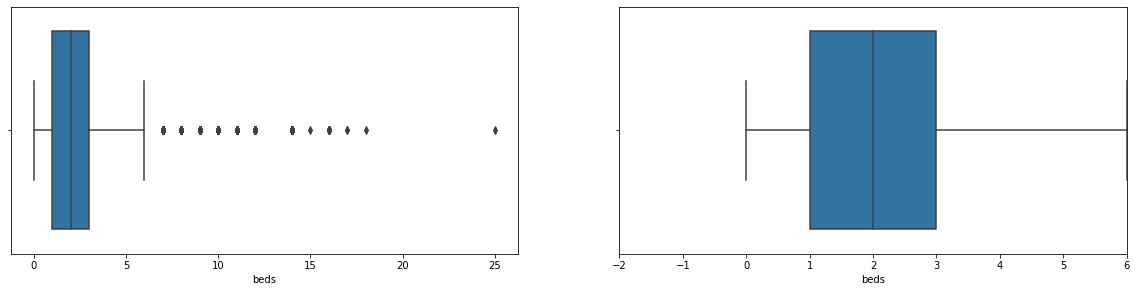

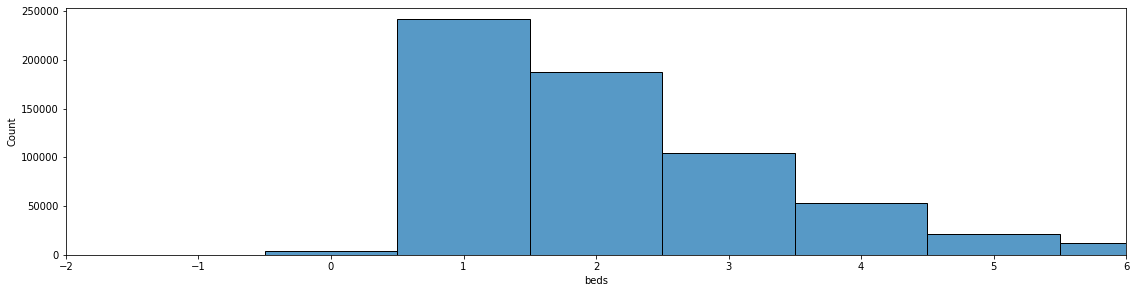

In [ ]:
diagrama_caixa(df['beds'])
grafico_barras(df['beds'])

Como existem poucos outliers, podemos excluir, pois eles não farão falta para a análise final. 

Poderiam ser deixados, por serem poucos também não impactariam muito o resultado, então por padrão serão excluídos.

In [ ]:
df, qtd_apagadas = exclui_outliers(df, 'beds')
print('Foram excluídas {} linhas.'.format(qtd_apagadas))

Foram excluídas 5622 linhas.


#### "guests_included" column analysis

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.


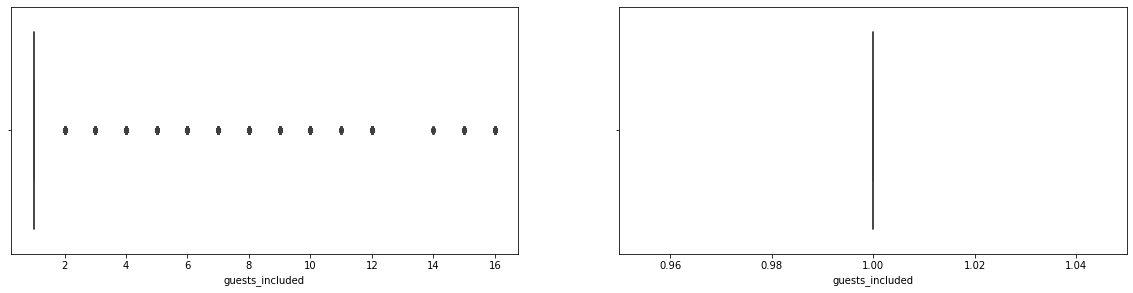

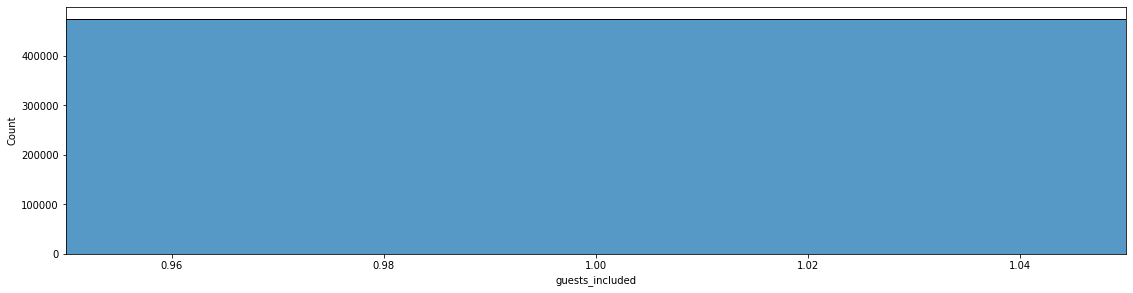

In [ ]:
diagrama_caixa(df['guests_included'])
grafico_barras(df['guests_included'])

Aqui não exlcuiremos os outliers, mas sim a coluna inteira, pois parece que o preenchimento por parte dos usuários é falho. 

Então vamos ignorar essa feature para não enviezar a análise final.

In [ ]:
df = df.drop('guests_included', axis = 1)
df.shape

(622366, 22)

#### "minimum_nights" column analysis

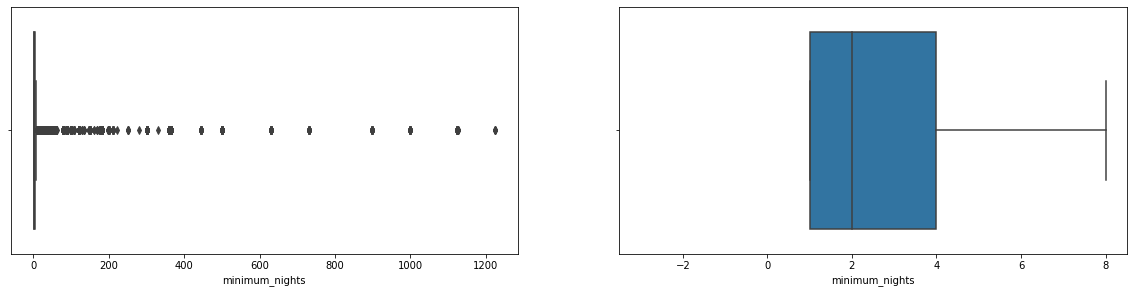

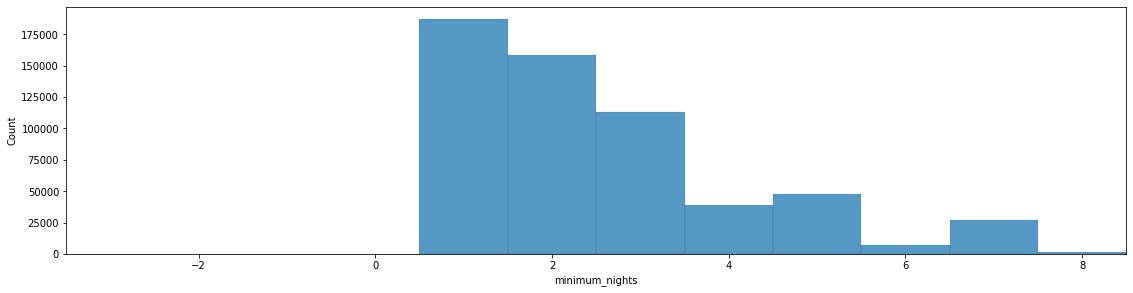

In [ ]:
diagrama_caixa(df['minimum_nights'])
grafico_barras(df['minimum_nights'])

Nesse caso podemos excluir os outliers, pois estamos querendo prever o valor para alugueis em tempo curtos, não para temporadas.

In [ ]:
df, qtd_apagadas = exclui_outliers(df, 'minimum_nights')
print('Foram excluídas {} linhas.'.format(qtd_apagadas))

Foram excluídas 40383 linhas.


#### "maximum_nights" column analysis   ***********

```
diagrama_caixa(df['maximum_nights'])
grafico_barras(df['maximum_nights'])
```

Nesse caso podemos excluir os outliers, pois esse dado não parece que ajudará na análise como um todo.

In [ ]:
df = df.drop('maximum_nights', axis = 1)
df.shape

(581983, 21)

#### "number_of_reviews" column analysis

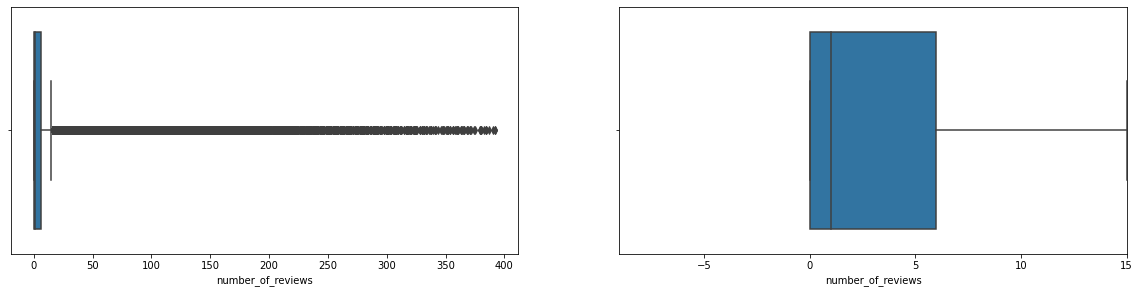

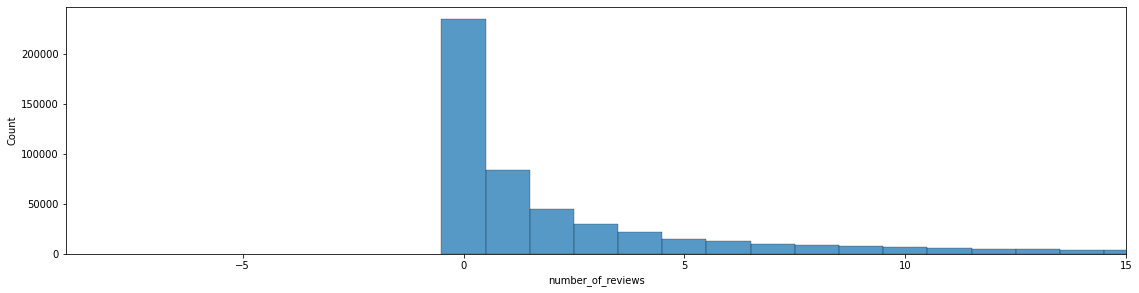

In [ ]:
diagrama_caixa(df['number_of_reviews'])
grafico_barras(df['number_of_reviews'])

Nesse caso podemos excluir os outliers, pois vamos escolher os hosts mais próximos de usuários iniciantes, ou seja, com poucos ou nenhum review.

In [ ]:
df, qtd_apagadas = exclui_outliers(df, 'number_of_reviews')
print('Foram excluídas {} linhas.'.format(qtd_apagadas))

Foram excluídas 80421 linhas.


### **Análises de textos categóricos**

#### "property_type" column analysis

Apartment                 393776
House                      48614
Condominium                22768
Serviced apartment          9062
Loft                        8850
Bed and breakfast           3102
Guest suite                 3044
Hostel                      2501
Guesthouse                  1892
Other                       1864
Villa                       1208
Townhouse                    788
Aparthotel                   496
Earth house                  468
Chalet                       440
Tiny house                   431
Boutique hotel               389
Hotel                        336
Casa particular (Cuba)       298
Cottage                      229
Bungalow                     181
Dorm                         158
Cabin                        110
Castle                        80
Nature lodge                  74
Boat                          53
Treehouse                     51
Hut                           40
Island                        39
Campsite                      34
Resort    

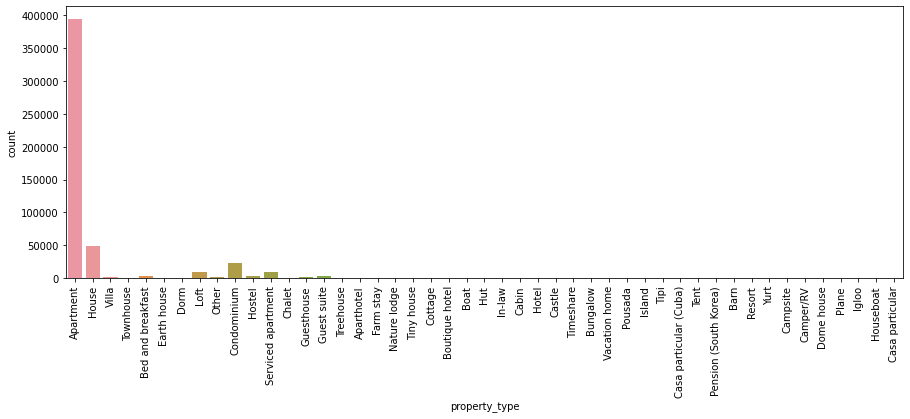

In [ ]:
print(df['property_type'].value_counts())

count_plot_text('property_type')

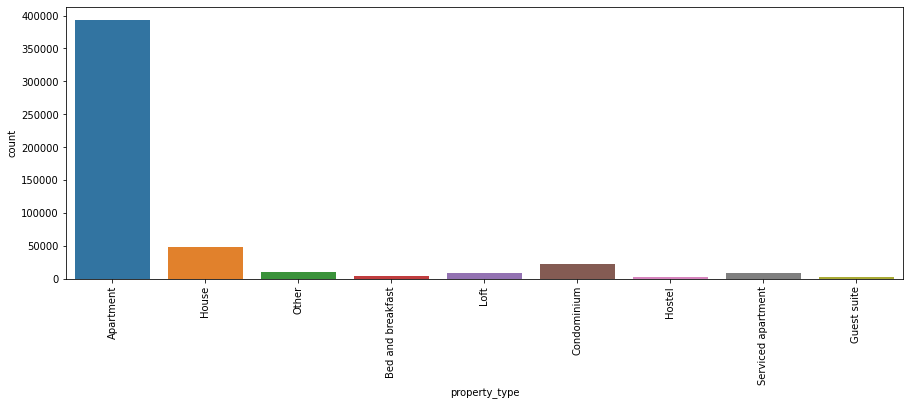

In [ ]:
tabela_tipos_casa = df['property_type'].value_counts()

outros_tipos = [tipo for tipo in tabela_tipos_casa.index if tabela_tipos_casa[tipo] < 2000]

for tipo in outros_tipos:
  df.loc[df['property_type'] == tipo, 'property_type'] = 'Other'

df['property_type'].value_counts()
count_plot_text('property_type')

#### "room_type" column analysis

Entire home/apt    310734
Private room       178687
Shared room         11448
Hotel room            693
Name: room_type, dtype: int64


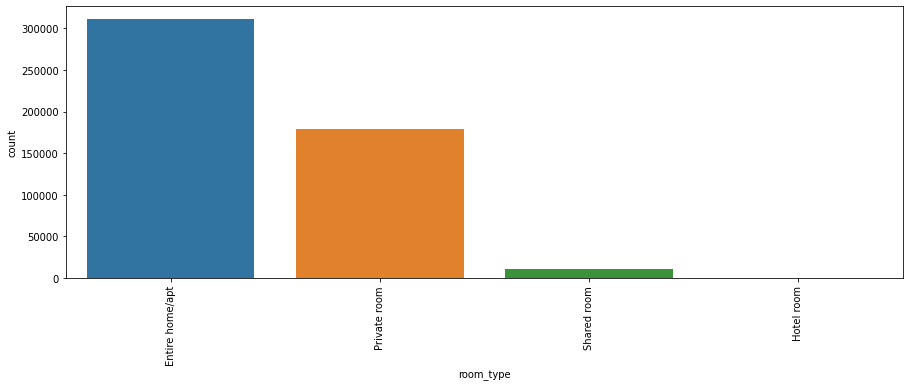

In [ ]:
print(df['room_type'].value_counts())

count_plot_text('room_type')

#### "bed_type" column analysis

Real Bed         491666
Pull-out Sofa      6843
Futon              1454
Airbed             1149
Couch               450
Name: bed_type, dtype: int64


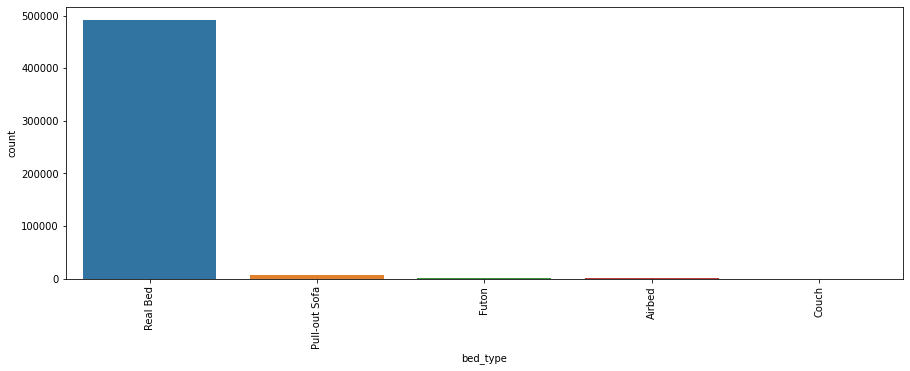

In [ ]:
count_plot_text('bed_type')

print(df['bed_type'].value_counts())

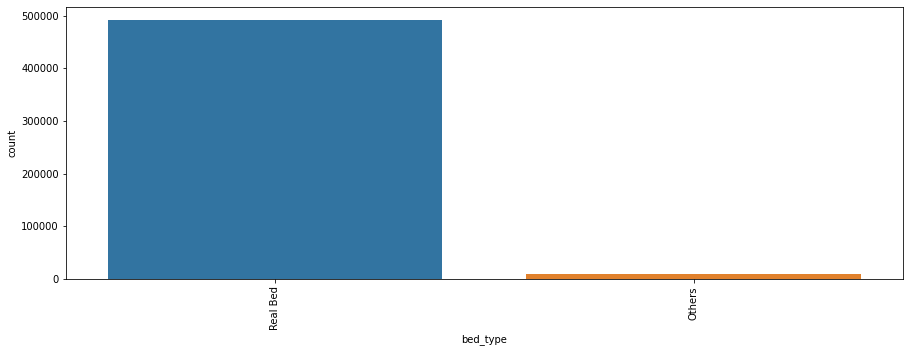

In [ ]:
tabela_tipos_casa = df['bed_type'].value_counts()

outros_tipos = [tipo for tipo in tabela_tipos_casa.index if tabela_tipos_casa[tipo] < 7000]

for tipo in outros_tipos:
  df.loc[df['bed_type'] == tipo, 'bed_type'] = 'Others'

df['bed_type'].value_counts()
count_plot_text('bed_type')

#### "cancellation_policy" column analysis

flexible                       247748
strict_14_with_grace_period    155117
moderate                        90661
strict                           7903
super_strict_60                   110
super_strict_30                    23
Name: cancellation_policy, dtype: int64


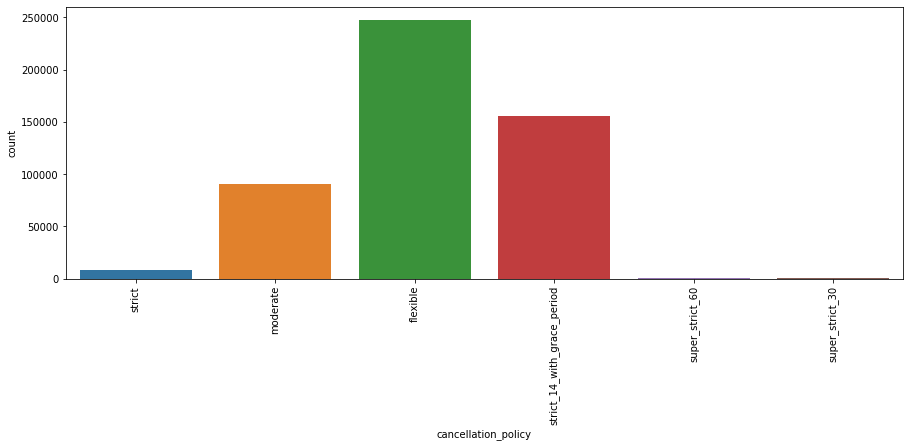

In [ ]:
count_plot_text('cancellation_policy')

print(df['cancellation_policy'].value_counts())

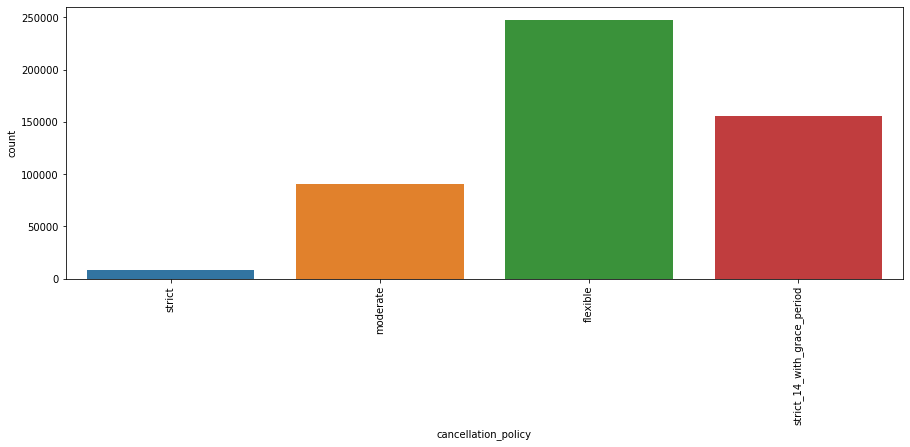

In [ ]:
tabela_tipos_casa = df['cancellation_policy'].value_counts()

outros_tipos = [tipo for tipo in tabela_tipos_casa.index if tabela_tipos_casa[tipo] < 8000]

for tipo in outros_tipos:
  df.loc[df['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'

df['cancellation_policy'].value_counts()
count_plot_text('cancellation_policy')

#### "amenities" column analysis

Para esse feature temos uma análise um pouco difernte, visto que mostra uma lista de comodidades possíveis. Como as comodidades são preenchidas pelo host, podemos ter muitas variações, por não haver padronização. 


A análise vai ser feita em cima da quantidade de comodidades declaradas, supondo que o host que declara mais comodidades tende a cobrar mais pela casa, enquanto o que declara menos comodidades, tende a ser mais modesto na precificação. 

É uma suposição, então pode ser que não seja veadeira, depois será feita a análise baseado nas previsões feitas.

In [ ]:
df['amenities'] = df['amenities'].str.split(',').apply(len)

df.shape

(501562, 21)

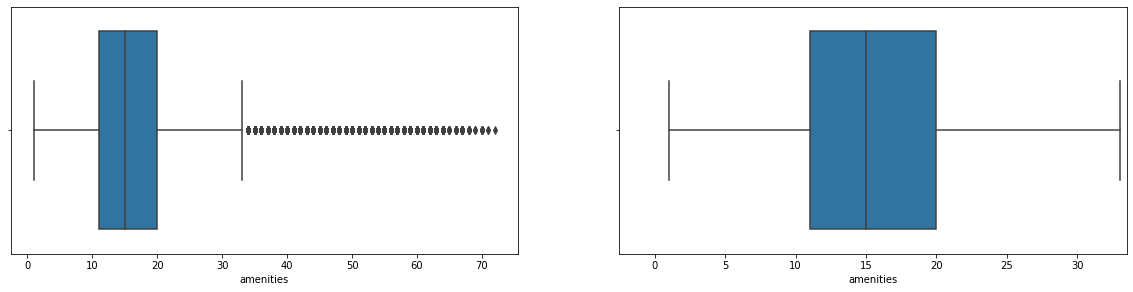

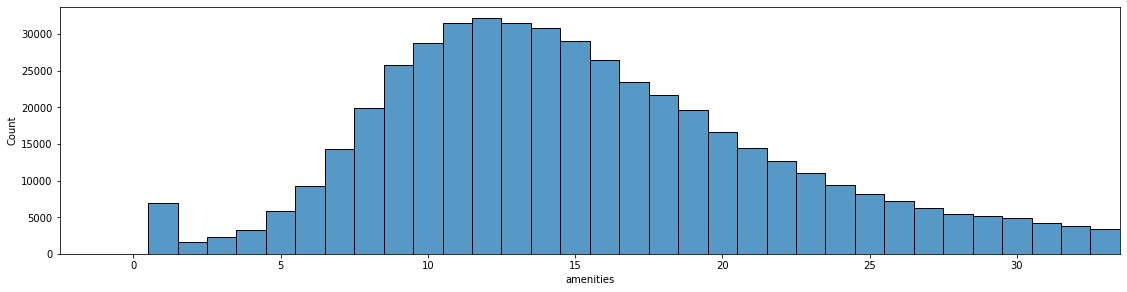

In [ ]:
diagrama_caixa(df['amenities'])
grafico_barras(df['amenities'])

In [ ]:
df, qtd_apagadas = exclui_outliers(df, 'host_listings_count')
print('Foram excluídas {} linhas.'.format(qtd_apagadas))

Foram excluídas 45473 linhas.


### **Análises de localização (mapa)**

In [ ]:
amostra = df.sample(n=50000) # Amostragem para o gráfico não ficar pesado e poluído

centro_mapa = {'lat': amostra.latitude.mean(), 'lon': amostra.longitude.mean()} # Cálcula centro fazendo média das medidas

mapa = px.density_mapbox(amostra, lat = 'latitude', lon = 'longitude', z = 'price', 
                  radius = 2.5, center = centro_mapa, zoom = 10, mapbox_style = 'stamen-terrain')

mapa.show()

### **Encoding**

Ajustar as features para simplificar e facilitar a análise do modelo. Transformar textos em números ou variáveis booleanas.**negrito**

#### **Feature com 2 categorias**

Atribui verdadeiro ou falso para presença ou ausência de alguma característica > Variáveis booleanas {0 ou 1}

Exemplo:

ID da casa | Tipo de cama
---------- | ------------
1          | Solteiro
2          | Casal
3          | Casal
4          | Casal
5          | Solteiro
6          | Casal
7          | Solteiro
8          | Solteiro


- Cama de solteiro: 0 (Falso)
- Cama de casal: 1 (Verdadeiro)

Ficará dessa forma:

ID da casa | Tipo de cama
---------- | ------------
1          | 0
2          | 1
3          | 1
4          | 1
5          | 0
6          | 1
7          | 0
8          | 0

In [ ]:
colunas_bool = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']

df_cod = df.copy()

for coluna in colunas_bool:
  df_cod.loc[df_cod[coluna] == 't', coluna] = 1
  df_cod.loc[df_cod[coluna] == 'f', coluna] = 0


df_cod.loc[df_cod['bed_type'] == 'Real Bed', 'bed_type'] = 1
df_cod.loc[df_cod['bed_type'] == 'Others', 'bed_type'] = 0

#### **Feature com 3 ou mais categorias**

Exemplo:

ID da casa | Tipo de cama
---------- | ------------
1          | Solteiro
2          | Casal
3          | Queen Size
4          | Casal
5          | Solteiro
6          | King Size
7          | Solteiro
8          | Beliche

> Opção 1: Variáveis Dummies ou OneHotEnconding (**opção escolhida**)

Cria colunas com cada uma das categorias e preenche elas com verdadeiro ou falso (1 OU 0), dependendo do atributo encontrado. Após adaptação ficará:

ID da casa | Solteiro | Casal | QueenSize | KingSize | Beliche
---------- | -------- | ----- | --------- | -------- | -------
1          |    1     |   0   |     0     |    0     |    0 
2          |    0     |   1   |     0     |    0     |    0
3          |    0     |   0   |     1     |    0     |    0
4          |    0     |   1   |     0     |    0     |    0
5          |    1     |   0   |     0     |    0     |    0
6          |    0     |   0   |     0     |    1     |    0
7          |    1     |   0   |     0     |    0     |    0
8          |    0     |   0   |     0     |    0     |    1

> Opção 2: Variáveis Numéricas inteiras

Poderiamos definir números inteiros para cada categoria, porém dessa forma o modelo criaria relações que não existem entre as classes.

ID da casa | Tipo de cama
---------- | ------------
1          | 0
2          | 1
3          | 2
4          | 1
5          | 0
6          | 3
7          | 0
8          | 4

In [ ]:
colunas_dummies = ['property_type', 'room_type', 'cancellation_policy']

df_cod = pd.get_dummies(data = df_cod, columns = colunas_dummies)

In [ ]:
df_cod.iloc[0]

host_is_superhost                                          0
host_listings_count                                      3.0
latitude                                           -22.92199
longitude                                         -43.183836
accommodates                                               3
bathrooms                                                1.0
bedrooms                                                 0.0
beds                                                     2.0
bed_type                                                   1
amenities                                                 14
price                                                  120.0
extra_people                                             0.0
minimum_nights                                             3
number_of_reviews                                          1
instant_bookable                                           0
is_business_travel_ready                                   0
mes                     

# Etapas avançadas - **Análises avançadas/ Machine learning**



In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.model_selection import train_test_split

### Modelo de Previsão

- Métricas de avaliação

In [ ]:
def avaliar_modelo(nome_modelo, y_teste, y_previsao):
  '''
  nome_modelo: Nome do modelo testado
  y_teste: dados reais, target
  y_previsao: dados obtidos pelo modelo, valores previstos
  '''
  r2 = r2_score(y_teste, y_previsao)
  RSME = mean_squared_error(y_teste, y_previsao)**(0.5)

  return f'Modelo {nome_modelo}: \nR²: {r2:.2%}\nRSME: {RSME:.3f}\n'

- Escolha dos modelos a serem testados
  1. RandomForest
  2. LinearRegression
  3. ExtraTrees

In [ ]:
modeloRandomForest = RandomForestRegressor()
modeloLinearRegression = LinearRegression()
modeloExtraTrees = ExtraTreesRegressor()

modelos = {'RandomForest' : modeloRandomForest,
           'LinearRegression': modeloLinearRegression,
           'ExtraTrees': modeloExtraTrees}

- Separação input e target (X e Y)

In [ ]:
y = df_cod['price'] # y em minúscuolo, pq é vetor
X = df_cod.drop('price', axis=1) #X em maiúsculo, pq é um array

- Separar dados de treino e de teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10) # random_state é a semente da aleatoridade, o número que é base para definir a divisã, ao defini-lo, temos ue a divisão sempre será a mesma em execuções diferentes.


### Análise do Melhor Modelo

In [ ]:
for nome, modelo in modelos.items():
  #treino
  modelo.fit(X_train, y_train)

In [ ]:
for nome, modelo in modelos.items():
  #teste
  previsao = modelo.predict(X_test)
  print(avaliar_modelo(nome, y_test, previsao))

Modelo RandomForest: 
R²: 96.74%
RSME: 49.849

Modelo LinearRegression: 
R²: 35.22%
RSME: 222.201

Modelo ExtraTrees: 
R²: 96.96%
RSME: 48.164



O modelo escolhido foi o ExtraTreesRegression, pois ele se saiu melhor nas duas métricas, obteve o maior R² e o menor RSME. 

A velocidade de treino e previsão desse e do so RandomForest foi praticamente a mesma, portanto manteremos o ExtraTreesRegression como nossa escolha. Caso o tempo fosse discrepante, talvez fosse melhor escolher o RandomForest, mas não foi o caso.

Modelo ExtraTrees: 
* R²: 96.95%
* RSME: 48.223

### Ajustes e Melhorias no Melhor Modelo

,0
bedrooms,0.103883
latitude,0.099164
longitude,0.088587
number_of_reviews,0.081382
room_type_Entire home/apt,0.080998
accommodates,0.073812
extra_people,0.073616
amenities,0.071946
bathrooms,0.064212
minimum_nights,0.061647


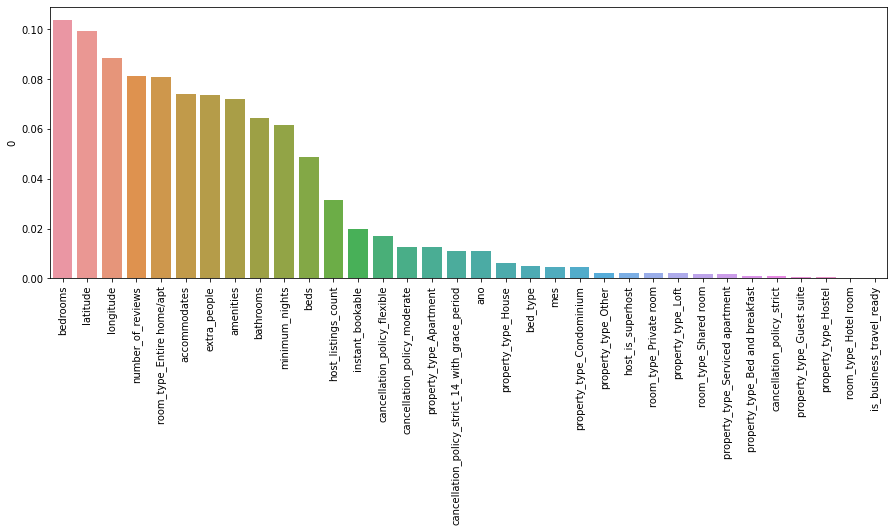

In [ ]:
importancia_features = pd.DataFrame(modeloExtraTrees.feature_importances_, X_train.columns).sort_values(by = 0, ascending = False)

plt.figure(figsize=(15,5))
sns.barplot(x = importancia_features.index, y = importancia_features[0]).tick_params(axis = 'x', rotation = 90)

importancia_features

Modelo ExtraTrees: 
R²: 96.97%
RSME: 48.019



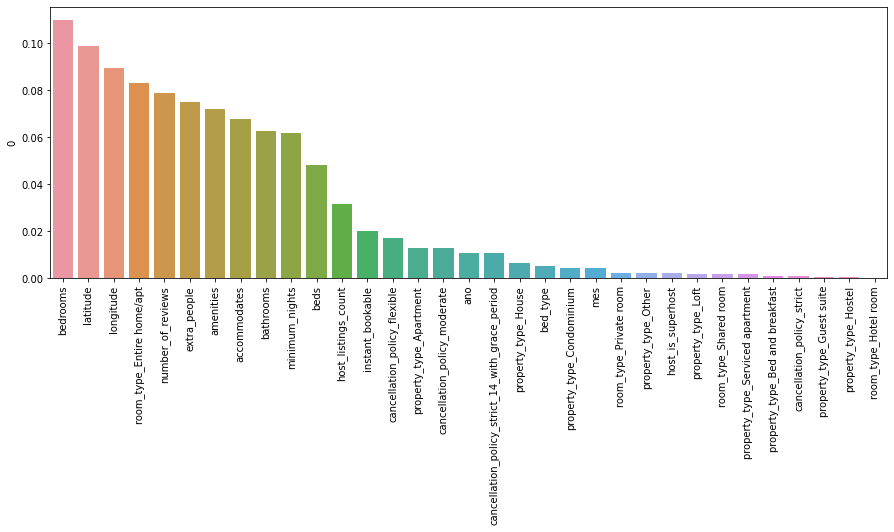

In [ ]:
colunas_pouco_importantes0 = ['is_business_travel_ready']

df_cod_adap0 = df_cod.drop(columns = colunas_pouco_importantes0)

# Separação target e inputs
y0 = df_cod_adap0['price']
X0 = df_cod_adap0.drop('price', axis=1)

# Separação treino e teste
X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, random_state = 10)

# Treino
modeloExtraTrees.fit(X_train0, y_train0)

# Previsão
previsao0 = modelo.predict(X_test0)

# Métricas
print(avaliar_modelo('ExtraTrees', y_test0, previsao0))

# Gráfico das importâncias
importancia_features0 = pd.DataFrame(modeloExtraTrees.feature_importances_, X_train0.columns).sort_values(by = 0, ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(x = importancia_features0.index, y = importancia_features0[0]).tick_params(axis = 'x', rotation = 90)

Modelo ExtraTrees: 
R²: 96.95%
RSME: 48.207



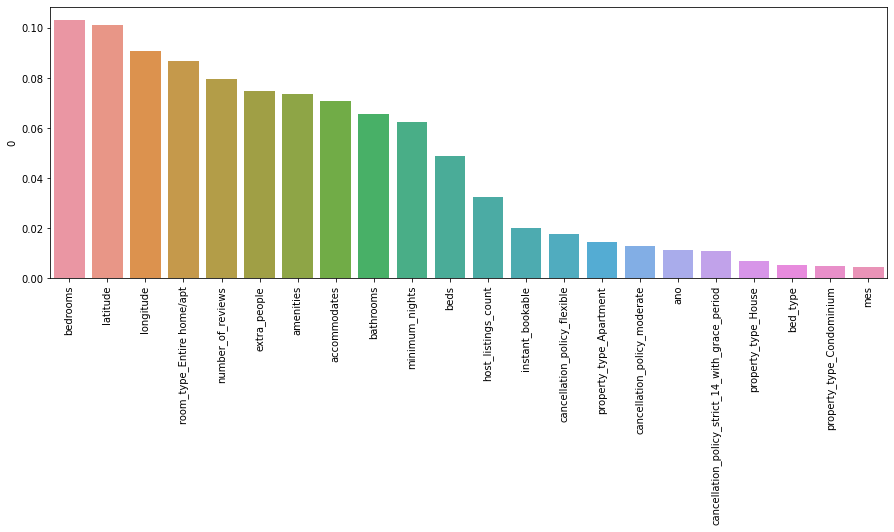

In [ ]:
colunas_pouco_importantes1 = [i for i in importancia_features.index if importancia_features[0][i] < 0.003]

df_cod_adap1 = df_cod.drop(columns = colunas_pouco_importantes1)

# Separação target e inputs
y1 = df_cod_adap1['price']
X1 = df_cod_adap1.drop('price', axis=1)

# Separação treino e teste
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 10)

# Treino
modeloExtraTrees.fit(X_train1, y_train1)

# Previsão
previsao1 = modelo.predict(X_test1)

# Métricas
print(avaliar_modelo('ExtraTrees', y_test1, previsao1))

# Gráfico das importâncias
importancia_features1 = pd.DataFrame(modeloExtraTrees.feature_importances_, X_train1.columns).sort_values(by = 0, ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(x = importancia_features1.index, y = importancia_features1[0]).tick_params(axis = 'x', rotation = 90)

Modelo ExtraTrees: 
R²: 96.75%
RSME: 49.755



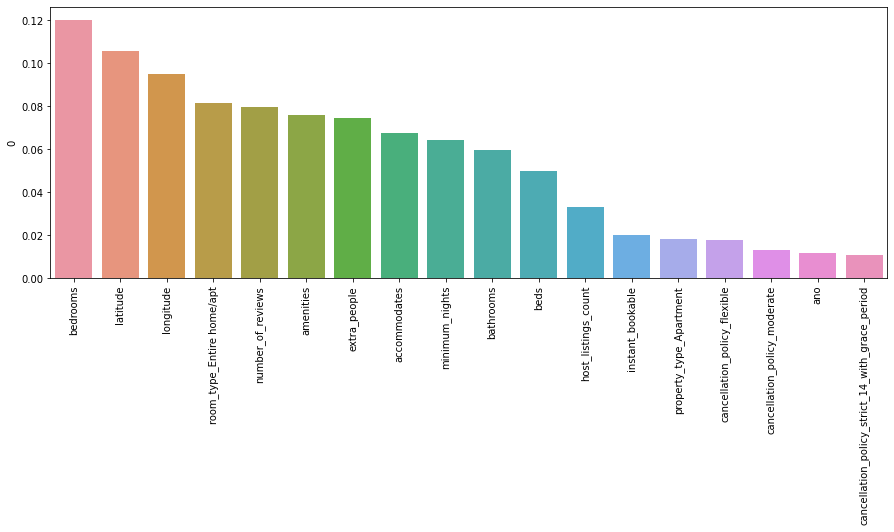

In [ ]:
colunas_pouco_importantes2 = [i for i in importancia_features.index if importancia_features[0][i] < 0.007]

df_cod_adap2 = df_cod.drop(columns = colunas_pouco_importantes2)

# Separação target e inputs
y2 = df_cod_adap2['price']
X2 = df_cod_adap2.drop('price', axis=1)

# Separação treino e teste
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 10)

# Treino
modeloExtraTrees.fit(X_train2, y_train2)

# Previsão
previsao2 = modelo.predict(X_test2)

# Métricas
print(avaliar_modelo('ExtraTrees', y_test2, previsao2))

# Gráfico das importâncias
importancia_features2 = pd.DataFrame(modeloExtraTrees.feature_importances_, X_train2.columns).sort_values(by = 0, ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(x = importancia_features2.index, y = importancia_features2[0]).tick_params(axis = 'x', rotation = 90)

# Deploy do Projeto


* **Passo 1** > Criar arquivo do modelo (joblib)

* **Passo 2** > Escolher a forma de deploy:
   * Arquivo executável (TKinter)
   * Deploy em um microsite (Flask)
   * Deploy apenas para uso direto (Streamlit)

* **Passo 3** > Outro arquivo Pytohn (pode ser Jupyter ou PyCharm)
* **Passo 4** > Importar streamlit e criar código
* **Passo 5** > Atribuir ao botão o carregamento do modelo
* **Passo 6** > Deploy feito

### Passo 1 > Criar arquivo do modelo

In [ ]:
X2['price'] = y2
X2.to_csv('dados.csv')

In [ ]:
import joblib

joblib.dump(modeloExtraTrees, 'modelo.joblib')

['modelo.joblib']

### Passo 2 > Escolha de forma de deploy